# Araba Fiyat Tahmini Projesi

In [1]:
# Gerekli Kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import re
from datetime import datetime

# Sklearn
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from scipy import stats

# CatBoost
from catboost import CatBoostRegressor

warnings.filterwarnings('ignore')
print('Kütüphaneler yüklendi')

Kütüphaneler yüklendi


## 1. Veri Yükleme

In [2]:
# Veri Yükleme
df_raw = pd.read_csv('vehicles.csv')
print(f'Ham veri boyutu: {df_raw.shape}')
print(f'Sütunlar: {list(df_raw.columns)}')

Ham veri boyutu: (426880, 26)
Sütunlar: ['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'image_url', 'description', 'county', 'state', 'lat', 'long', 'posting_date']


## 2. Veri Temizleme

In [3]:
# Temel veri temizleme
df = df_raw.copy()

# Gerekli kolonları seç
required_cols = ['price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 
                 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'url']

df = df[required_cols].copy()

# Fiyat filtreleme
df = df[(df['price'] >= 1000) & (df['price'] <= 100000)]

# Yıl filtreleme (null olmayanlar için)
df = df[(df['year'].isna()) | ((df['year'] >= 1990) & (df['year'] <= 2024))]

# Kilometre filtreleme (null olmayanlar için)
df = df[(df['odometer'].isna()) | ((df['odometer'] >= 0) & (df['odometer'] <= 500000))]

# Manufacturer null'ları doldur
df['manufacturer'] = df['manufacturer'].fillna('unknown')

# Kategorik değişkenlerdeki null'ları unkown ile doldur (model HARİÇ - sonra normalize edilecek)
categorical_cols = ['condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type']
for col in categorical_cols:
    df[col] = df[col].fillna('unknown')

# Cylinders'ı numerik yap
def extract_cylinders(x):
    if pd.isna(x) or x == 'unknown':
        return np.nan
    try:
        return int(str(x).split()[0])
    except:
        return np.nan

df['cylinders'] = df['cylinders'].apply(extract_cylinders)

print(f'Temizlenmiş veri boyutu: {df.shape}')
print(f'\nNull değerler:')
print(df[['year', 'odometer', 'cylinders', 'model']].isnull().sum())

Temizlenmiş veri boyutu: (367448, 13)

Null değerler:
year           1163
odometer       2049
cylinders    151921
model          3391
dtype: int64


## 2.1 Model Kolonu Normalizasyonu (URL'den Çıkarma)

Bu bölümde:
1. Model sözlüğü tanımlanır
2. Model isimleri normalize edilir
3. URL'den model çıkarılır ve boş değerler doldurulur

In [4]:
# MODEL SÖZLÜĞÜ
print("=" * 80)
print("MODEL SÖZLÜĞÜ")
print("=" * 80)

models_by_brand = {
    'ford': [
        'f-150', 'f-250', 'f-350', 'mustang', 'explorer', 'escape', 'focus', 'fusion',
        'edge', 'expedition', 'ranger', 'taurus', 'fiesta', 'flex', 'bronco',
        'ecosport', 'transit', 'c-max', 'crown victoria', 'thunderbird', 'excursion',
        'freestar', 'windstar', 'contour', 'probe', 'aspire', 'aerostar', 'gt',
        'bronco sport'
    ],
    'chevrolet': [
        'silverado 1500', 'silverado 2500', 'silverado 3500', 'camaro', 'corvette',
        'malibu', 'equinox', 'tahoe', 'suburban', 'traverse', 'impala', 'cruze',
        'blazer', 'colorado', 'trax', 'sonic', 'spark', 'volt', 'bolt', 'avalanche',
        'trailblazer', 'ssr', 'hhr', 'cobalt', 'cavalier', 'monte carlo', 's-10',
        'astro', 'express', 'venture', 'uplander'
    ],
    'toyota': [
        'camry', 'corolla', 'rav4', 'tacoma', 'tundra', '4runner', 'highlander',
        'prius', 'sienna', 'avalon', 'sequoia', 'land cruiser', 'yaris', 'matrix',
        'venza', 'fj cruiser', 'c-hr', 'supra', '86', 'celica', 'mr2', 'echo',
        'solara', 'previa', 't100'
    ],
    'honda': [
        'civic', 'accord', 'cr-v', 'pilot', 'odyssey', 'fit', 'hr-v', 'ridgeline',
        'passport', 'element', 'insight', 'cr-z', 's2000', 'prelude', 'del sol',
        'crosstour'
    ],
    'nissan': [
        'altima', 'sentra', 'rogue', 'maxima', 'pathfinder', 'frontier', 'titan',
        'murano', 'versa', 'juke', 'armada', 'leaf', '370z', '350z', '300zx',
        'quest', 'xterra', 'kicks', 'cube', 'gt-r', '240sx', 'stanza', 'pulsar', 'nx'
    ],
    'jeep': [
        'wrangler', 'grand cherokee', 'cherokee', 'compass', 'renegade', 'gladiator',
        'patriot', 'liberty', 'commander', 'wagoneer', 'grand wagoneer'
    ],
    'ram': [
        '1500', '2500', '3500', 'promaster', 'dakota'
    ],
    'gmc': [
        'sierra 1500', 'sierra 2500', 'sierra 3500', 'yukon', 'yukon xl', 'acadia',
        'terrain', 'canyon', 'savana', 'envoy', 'jimmy', 'sonoma', 'safari',
        'syclone', 'typhoon'
    ],
    'bmw': [
        '3 series', '5 series', '7 series', 'x3', 'x5', 'x1', 'x6', '2 series',
        '4 series', '6 series', '8 series', 'x2', 'x4', 'x7', 'z3', 'z4', 'm3',
        'm5', 'i3', 'i8', '1 series'
    ],
    'dodge': [
        'charger', 'challenger', 'durango', 'journey', 'grand caravan', 'dart',
        'avenger', 'caliber', 'neon', 'stratus', 'intrepid', 'dakota', 'ram',
        'viper', 'magnum', 'nitro', 'caravan', 'spirit', 'shadow', 'stealth'
    ],
    'mercedes-benz': [
        'c-class', 'e-class', 's-class', 'gle', 'glc', 'gla', 'glb', 'gls', 'cla',
        'a-class', 'b-class', 'g-class', 'sl-class', 'slk-class', 'cls-class',
        'ml-class', 'gl-class', 'glk-class', 'r-class', 'sprinter', 'metris'
    ],
    'hyundai': [
        'elantra', 'sonata', 'tucson', 'santa fe', 'accent', 'kona', 'palisade',
        'veloster', 'genesis', 'azera', 'venue', 'ioniq', 'tiburon', 'excel',
        'scoupe', 'entourage'
    ],
    'subaru': [
        'outback', 'forester', 'impreza', 'legacy', 'crosstrek', 'ascent', 'wrx',
        'brz', 'baja', 'tribeca', 'svx'
    ],
    'volkswagen': [
        'jetta', 'passat', 'tiguan', 'atlas', 'golf', 'beetle', 'gti', 'touareg',
        'arteon', 'cc', 'eos', 'cabrio', 'rabbit', 'routan', 'phaeton', 'corrado',
        'eurovan'
    ],
    'kia': [
        'soul', 'optima', 'sorento', 'sportage', 'forte', 'telluride', 'sedona',
        'rio', 'stinger', 'niro', 'seltos', 'k5', 'cadenza', 'amanti', 'spectra',
        'sephia', 'rondo'
    ],
    'lexus': [
        'es', 'rx', 'is', 'gx', 'nx', 'ux', 'ls', 'lx', 'gs', 'rc', 'lc', 'ct',
        'hs', 'sc', 'lfa'
    ],
    'audi': [
        'a4', 'a6', 'q5', 'q7', 'a3', 'q3', 'a5', 'a8', 'q8', 'tt', 'r8', 's4',
        's5', 's6', 'rs5', 'rs7', 'e-tron', 'allroad', 'a7'
    ],
    'cadillac': [
        'escalade', 'xt5', 'ct6', 'cts', 'ats', 'srx', 'xt4', 'xts', 'dts', 'sts',
        'deville', 'eldorado', 'catera', 'xlr', 'elr', 'ct4', 'ct5'
    ],
    'chrysler': [
        '300', 'pacifica', '200', 'town & country', 'town and country', 'town country',
        'sebring', 'concorde', 'lhs', 'crossfire', 'pt cruiser', 'cirrus', 'aspen',
        'voyager'
    ],
    'acura': [
        'mdx', 'tlx', 'rdx', 'ilx', 'nsx', 'tsx', 'tl', 'rl', 'rsx', 'integra',
        'legend', 'vigor', 'cl', 'zdx', 'rlx'
    ],
    'buick': [
        'enclave', 'encore', 'envision', 'lacrosse', 'regal', 'lucerne', 'lesabre',
        'century', 'park avenue', 'rendezvous', 'rainier', 'terraza', 'riviera',
        'roadmaster'
    ],
    'mazda': [
        'mazda3', 'mazda6', 'cx-5', 'cx-9', 'cx-3', 'cx-30', 'mx-5 miata', 'cx-7',
        'tribute', 'mpv', 'protege', '626', 'millenia', 'rx-7', 'rx-8', 'b-series'
    ],
    'infiniti': [
        'q50', 'q60', 'qx60', 'qx80', 'qx50', 'qx30', 'g35', 'g37', 'm35', 'm37',
        'fx35', 'fx45', 'ex35', 'jx35', 'qx4', 'i30', 'i35', 'q45'
    ],
    'lincoln': [
        'navigator', 'aviator', 'nautilus', 'corsair', 'continental', 'mkz',
        'mkx', 'mkc', 'mks', 'mkt', 'town car', 'ls', 'zephyr', 'mark lt',
        'blackwood'
    ],
    'volvo': [
        'xc90', 'xc60', 's60', 's90', 'v60', 'v90', 'xc40', 'xc70', 's40', 'v50',
        'v70', 'c30', 'c70', '240', '850', '940', '960'
    ],
    'mitsubishi': [
        'outlander', 'eclipse', 'lancer', 'mirage', 'outlander sport', 'montero',
        'galant', 'diamante', '3000gt', 'eclipse cross', 'endeavor', 'raider'
    ],
    'mini': [
        'cooper', 'countryman', 'clubman', 'paceman', 'coupe', 'roadster', 'convertible'
    ],
    'pontiac': [
        'grand prix', 'grand am', 'g6', 'g5', 'vibe', 'sunfire', 'bonneville',
        'firebird', 'trans am', 'aztek', 'montana', 'torrent', 'solstice', 'gto',
        'fiero'
    ],
    'rover': [
        '75', '45', '25', '200', '400', '600', '800', 'metro', 'mini', 'range rover'
    ],
    'jaguar': [
        'f-pace', 'e-pace', 'i-pace', 'xf', 'xe', 'xj', 'f-type', 'x-type',
        's-type', 'xk', 'xjs', 'xjr'
    ],
    'porsche': [
        '911', 'cayenne', 'macan', 'panamera', 'boxster', 'cayman', '718',
        'taycan', '944', '928', '968'
    ],
    'mercury': [
        'grand marquis', 'sable', 'mountaineer', 'mariner', 'milan', 'montego',
        'cougar', 'mystique', 'villager', 'tracer', 'topaz'
    ],
    'saturn': [
        'vue', 'ion', 'outlook', 'aura', 'sky', 'l-series', 's-series', 'relay'
    ],
    'alfa-romeo': [
        'giulia', 'stelvio', '4c', 'spider', '164', '156', '147', 'gtv', 'brera'
    ],
    'tesla': [
        'model s', 'model 3', 'model x', 'model y', 'roadster', 'cybertruck'
    ],
    'fiat': [
        '500', '500l', '500x', '124 spider', 'panda', 'punto', 'bravo', 'ducato'
    ],
    'harley-davidson': [
        'sportster', 'softail', 'touring', 'street', 'v-rod', 'dyna'
    ],
    'ferrari': [
        '488', 'f8', '812', 'roma', 'portofino', 'sf90', '458', 'california',
        '599', '612', 'f12', 'laferrari', 'enzo', '360', '550', '575', 'testarossa'
    ],
    'datsun': [
        '280z', '240z', '260z', '510', '620', '720', 'b210', '200sx'
    ],
    'aston-martin': [
        'db9', 'db11', 'dbs', 'vantage', 'rapide', 'vanquish', 'virage',
        'v8 vantage', 'dbx'
    ],
    'land rover': [
        'range rover', 'range rover sport', 'range rover evoque', 'discovery',
        'defender', 'lr2', 'lr3', 'lr4', 'freelander'
    ],
    'morgan': [
        'plus 4', 'plus 6', '4/4', 'roadster', 'aero', '3 wheeler'
    ],
}

print(f"Toplam marka sayısı: {len(models_by_brand)}")
print(f"Toplam model sayısı: {sum(len(v) for v in models_by_brand.values())}")


MODEL SÖZLÜĞÜ
Toplam marka sayısı: 42
Toplam model sayısı: 603


In [5]:
# MODEL VARYANTLARI VE URL İŞLEME FONKSİYONLARI
print("="*80)
print("MODEL VARYANTLARI VE URL İŞLEME FONKSİYONLARI")
print("="*80)

def generate_model_variants(model_name):
    """Bir model ismi için tüm olası varyasyonları üretir."""
    variants = set()
    variants.add(model_name.lower().strip())
    
    if '-' in model_name:
        variants.add(model_name.replace('-', ''))
        variants.add(model_name.replace('-', ' '))
    
    if ' ' in model_name:
        variants.add(model_name.replace(' ', '-'))
        variants.add(model_name.replace(' ', ''))
    
    matches = re.findall(r'([a-z]+)(\d+)', model_name.replace('-', '').replace(' ', ''))
    if matches:
        for letter, number in matches:
            variants.add(f"{letter}-{number}")
            variants.add(f"{letter} {number}")
    
    return list(variants)

# Varyantları içeren genişletilmiş sözlük
all_known_models = set()
all_model_variants = {}

for brand, models in models_by_brand.items():
    for model_name in models:
        all_known_models.add(model_name.lower())
        variants = generate_model_variants(model_name)
        for variant in variants:
            all_model_variants[variant.lower()] = model_name.lower()

print(f"Toplam bilinen model sayısı: {len(all_known_models)}")
print(f"Toplam varyant sayısı: {len(all_model_variants)}")

# URL İşleme Fonksiyonları
def normalize_url_to_tokens(url):
    """URL'yi normalize edip token listesi döndürür."""
    u = str(url).lower().strip()
    if '://' in u:
        u = u.split('://', 1)[1]
    if '/' in u:
        u = u.split('/', 1)[1]

    u = u.replace('%20', ' ')
    for ch in ['-', '_', '/', '.', ',', ';']:
        u = u.replace(ch, ' ')
    u = re.sub(r'\s+', ' ', u).strip()
    if not u:
        return []
    return u.split(' ')

def model_tokens(model_name):
    """Model ismini token listesine çevirir."""
    m = str(model_name).lower().strip()
    m = m.replace('%20', ' ')
    for ch in ['-', '_', '/', '.', ',', ';']:
        m = m.replace(ch, ' ')
    m = re.sub(r'\s+', ' ', m).strip()
    if not m:
        return []
    return m.split(' ')

def contains_model(tokens, model_name):
    """URL token listesi içinde model ardışık olarak geçiyor mu?"""
    mtoks = model_tokens(model_name)
    if not mtoks:
        return False
    n, k = len(tokens), len(mtoks)
    if k == 0 or n < k:
        return False
    for i in range(n - k + 1):
        if tokens[i:i+k] == mtoks:
            return True
    return False

def extract_model_from_url_with_variants(url, manufacturer):
    """URL'den model çıkartır, tüm varyantları kontrol eder."""
    if pd.isna(url) or pd.isna(manufacturer):
        return None

    manu = str(manufacturer).lower().strip()
    model_list = models_by_brand.get(manu)
    if not model_list:
        return None

    tokens = normalize_url_to_tokens(url)
    
    for model_name in model_list:
        variants = generate_model_variants(model_name)
        for variant in variants:
            if contains_model(tokens, variant):
                return model_name.lower()
    
    return None

print("\nFonksiyonlar tanımlandı")

MODEL VARYANTLARI VE URL İŞLEME FONKSİYONLARI
Toplam bilinen model sayısı: 596
Toplam varyant sayısı: 952

Fonksiyonlar tanımlandı


In [6]:
# MODEL SÜTUNU TEMİZLEME VE NORMALİZASYON
print("="*80)
print("MODEL SÜTUNU TEMİZLEME VE NORMALİZASYON")
print("="*80)

# 1) Basic temizlik
df['model_clean'] = (
    df['model']
      .astype(str)
      .str.lower()
      .str.strip()
      .replace({'nan': None, 'none': None, '': None})
)

print(f"Ham model NaN sayısı: {df['model_clean'].isna().sum():,}")

# 2) Normalizasyon fonksiyonu
def normalize_model_variants(s):
    """Model ismini normalize et"""
    if pd.isna(s):
        return None
    
    t = str(s).lower().strip()
    t = re.sub(r'[^a-z0-9\s\-]', '', t)
    t = re.sub(r'\s+', ' ', t).strip()
    
    if not t:
        return None
    
    # Varyant sözlüğünde varsa canonical halini al
    if t in all_model_variants:
        return all_model_variants[t]
    
    return t

df['model_normalized'] = df['model_clean'].apply(normalize_model_variants)

print(f"Normalize edilmiş model sayısı: {df['model_normalized'].notna().sum():,}")

# 3) Sözlükte olmayanları None yap
mask_not_in_dict = (
    df['model_normalized'].notna() & 
    (~df['model_normalized'].isin(all_known_models))
)

silinen_count = mask_not_in_dict.sum()
print(f"\nSözlükte olmayan ve silinen model sayısı: {silinen_count:,}")

df.loc[mask_not_in_dict, 'model_normalized'] = None

print(f"\nTemizlik sonrası:")
print(f"   model_normalized NaN: {df['model_normalized'].isna().sum():,}")
print(f"   model_normalized dolu: {df['model_normalized'].notna().sum():,}")

MODEL SÜTUNU TEMİZLEME VE NORMALİZASYON
Ham model NaN sayısı: 3,391
Normalize edilmiş model sayısı: 364,048

Sözlükte olmayan ve silinen model sayısı: 207,191

Temizlik sonrası:
   model_normalized NaN: 210,591
   model_normalized dolu: 156,857


In [7]:
# URL'DEN MODEL ÇIKARTMA VE DOLDURMA
print("="*80)
print("URL'DEN MODEL ÇIKARTMA")
print("="*80)

# URL'den model çıkar
df['model_from_url'] = df.apply(
    lambda row: extract_model_from_url_with_variants(row['url'], row['manufacturer']),
    axis=1
)

found_count = df['model_from_url'].notna().sum()
print(f"\n1) URL'den bulunan model sayısı: {found_count:,} ({found_count / len(df) * 100:.2f}%)")

# Boş satırları URL'den doldur
mask_empty = df['model_normalized'].isna()
mask_has_url_model = df['model_from_url'].notna()
mask_to_fill = mask_empty & mask_has_url_model

doldurulan = mask_to_fill.sum()
print(f"\n2) Boş satırlarda URL'den doldurulan model sayısı: {doldurulan:,}")

df.loc[mask_to_fill, 'model_normalized'] = df.loc[mask_to_fill, 'model_from_url']

# Final durum
nan_final = df['model_normalized'].isna().sum()
dolu_final = df['model_normalized'].notna().sum()

print(f"\n3) DOLDURMA SONRASI:")
print(f"   model_normalized NaN: {nan_final:,} ({nan_final/len(df)*100:.2f}%)")
print(f"   model_normalized dolu: {dolu_final:,} ({dolu_final/len(df)*100:.2f}%)")

# Boş kalanları 'unknown' yap
df['model_normalized'] = df['model_normalized'].fillna('unknown')

print(f"\n4) Final model_normalized durumu:")
print(f"   Farklı model sayısı: {df['model_normalized'].nunique()}")

print("\nEn sık 30 model:")
print(df['model_normalized'].value_counts(dropna=True).head(30).to_string())

URL'DEN MODEL ÇIKARTMA

1) URL'den bulunan model sayısı: 273,246 (74.36%)

2) Boş satırlarda URL'den doldurulan model sayısı: 143,752

3) DOLDURMA SONRASI:
   model_normalized NaN: 66,839 (18.19%)
   model_normalized dolu: 300,609 (81.81%)

4) Final model_normalized durumu:
   Farklı model sayısı: 536

En sık 30 model:
model_normalized
unknown           66839
f-150             11940
1500               8208
wrangler           6959
silverado 1500     5376
tacoma             5236
civic              5116
accord             4723
camry              4459
f-250              4017
sierra 1500        3967
escape             3838
2500               3797
explorer           3445
mustang            3385
grand cherokee     3335
altima             3314
tundra             3183
corolla            3021
focus              3003
fusion             2824
equinox            2712
f-350              2683
sonata             2641
tahoe              2477
cruze              2472
cr-v               2394
jetta         

MODEL DAĞILIMI (URL'den Çıkarma Sonrası)


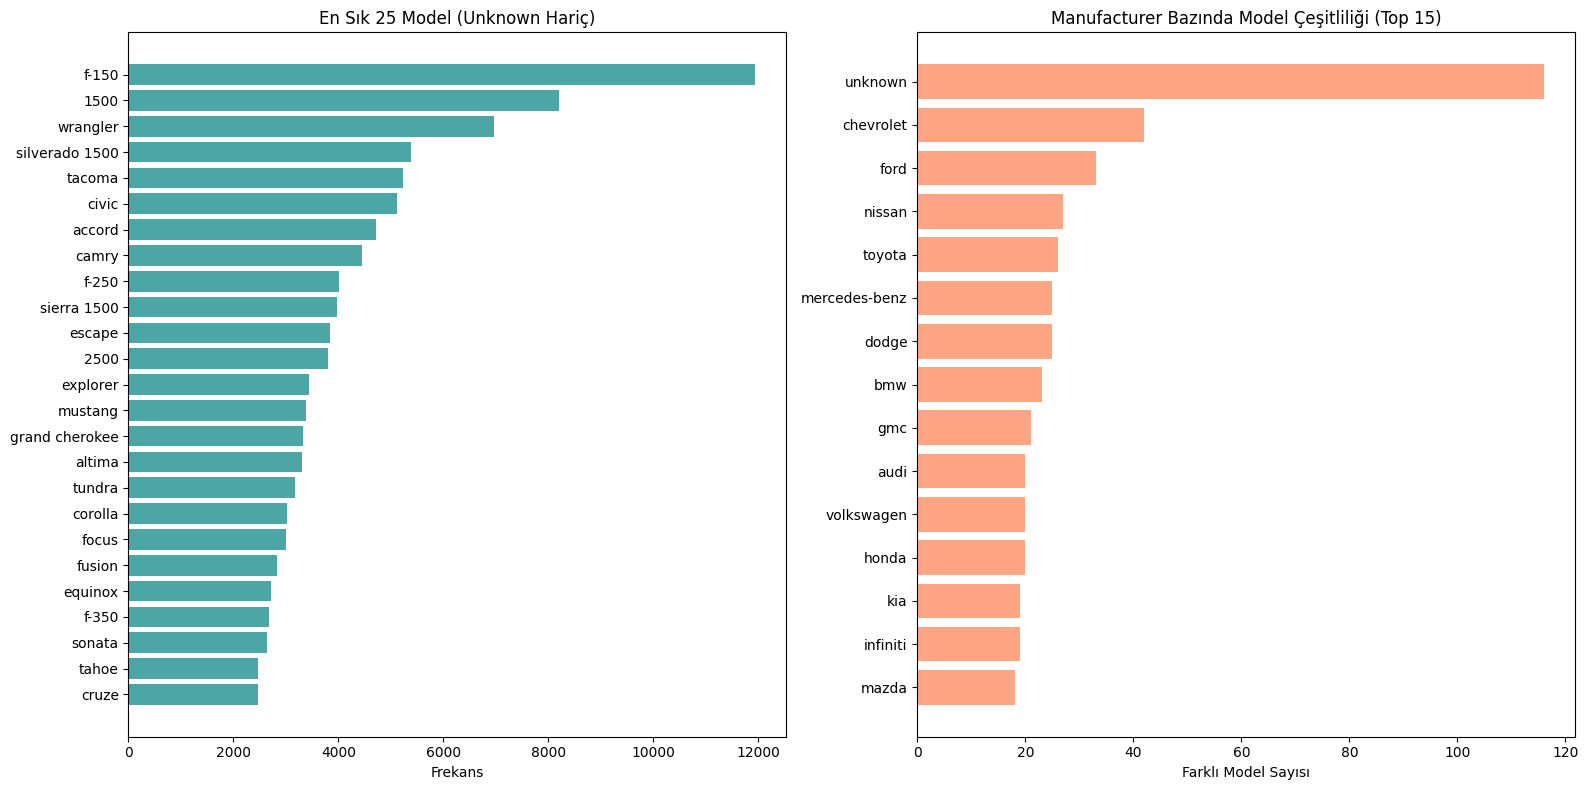


Toplam farklı model sayısı: 536
Unknown oranı: 18.19%


In [8]:
# MODEL DAĞILIMI GRAFİĞİ
print('='*60)
print("MODEL DAĞILIMI (URL'den Çıkarma Sonrası)")
print('='*60)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 1. En sık 25 model (unknown hariç)
model_counts = df[df['model_normalized'] != 'unknown']['model_normalized'].value_counts().head(25)
axes[0].barh(model_counts.index, model_counts.values, color='teal', alpha=0.7)
axes[0].set_title('En Sık 25 Model (Unknown Hariç)', fontsize=12)
axes[0].set_xlabel('Frekans')
axes[0].invert_yaxis()

# 2. Manufacturer bazında model çeşitliliği
model_variety = df.groupby('manufacturer')['model_normalized'].nunique().sort_values(ascending=False).head(15)
axes[1].barh(model_variety.index, model_variety.values, color='coral', alpha=0.7)
axes[1].set_title('Manufacturer Bazında Model Çeşitliliği (Top 15)', fontsize=12)
axes[1].set_xlabel('Farklı Model Sayısı')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\nToplam farklı model sayısı: {df['model_normalized'].nunique()}")
print(f"Unknown oranı: {(df['model_normalized'] == 'unknown').sum() / len(df) * 100:.2f}%")

In [9]:
# Gereksiz kolonları sil
df = df.drop(columns=['model', 'model_clean', 'model_from_url', 'url'])
print(f"Final kolonlar: {list(df.columns)}")
print(f"Final veri boyutu: {df.shape}")

Final kolonlar: ['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'model_normalized']
Final veri boyutu: (367448, 12)


## 3. TRAIN-TEST SPLIT

In [10]:
# Split işlemini en başta yapıyoruz, bu şekilde data leakage'ın önüne geçiyoruz
# Henüz hiçbir feature engineering veya analiz yapılmadı

# Feature ve Target ayırma
X = df.drop('price', axis=1)
y = df['price']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print('='*60)
print('TRAIN/TEST SPLIT')
print('='*60)
print(f'X_train: {X_train.shape}')
print(f'X_test:  {X_test.shape}')
print(f'Ortalama fiyat ($): Train=${y_train.mean():,.0f}, Test=${y_test.mean():,.0f}')
print('\nTest verisi artık izole edildi - hiçbir analiz test verisini görmeyecek')

TRAIN/TEST SPLIT
X_train: (293958, 11)
X_test:  (73490, 11)
Ortalama fiyat ($): Train=$19,464, Test=$19,538

Test verisi artık izole edildi - hiçbir analiz test verisini görmeyecek


In [11]:
# Null değerleri train-test split sonrası doldurma
# Train'den hesaplanan değerlerle hem train hem test doldurulacak

print('='*60)
print('NULL DEĞER DOLDURMA')
print('='*60)

# Kopyalar oluştur
X_train = X_train.copy()
X_test = X_test.copy()

# 1) YEAR - Train median ile doldur
year_median_train = X_train['year'].median()
print(f'\n1) YEAR null doldurma:')
print(f'   Train null sayısı: {X_train["year"].isnull().sum()}')
print(f'   Test null sayısı: {X_test["year"].isnull().sum()}')
print(f'   Train median (kullanılacak): {year_median_train}')

X_train['year'] = X_train['year'].fillna(year_median_train)
X_test['year'] = X_test['year'].fillna(year_median_train)  # Train median kullanılıyor!
print(f'   ✓ Dolduruldu')

# 2) ODOMETER - Train median ile doldur
odometer_median_train = X_train['odometer'].median()
print(f'\n2) ODOMETER null doldurma:')
print(f'   Train null sayısı: {X_train["odometer"].isnull().sum()}')
print(f'   Test null sayısı: {X_test["odometer"].isnull().sum()}')
print(f'   Train median (kullanılacak): {odometer_median_train:,.0f}')

X_train['odometer'] = X_train['odometer'].fillna(odometer_median_train)
X_test['odometer'] = X_test['odometer'].fillna(odometer_median_train)  # Train median kullanılıyor!
print(f'   ✓ Dolduruldu')

# 3) MANUFACTURER - Train mode ile doldur
manufacturer_mode_train = X_train['manufacturer'].mode()[0] if not X_train['manufacturer'].mode().empty else 'unknown'
print(f'\n3) MANUFACTURER null doldurma:')
print(f'   Train null sayısı: {X_train["manufacturer"].isnull().sum()}')
print(f'   Test null sayısı: {X_test["manufacturer"].isnull().sum()}')
print(f'   Train mode (kullanılacak): {manufacturer_mode_train}')

X_train['manufacturer'] = X_train['manufacturer'].fillna(manufacturer_mode_train)
X_test['manufacturer'] = X_test['manufacturer'].fillna(manufacturer_mode_train)  # Train mode kullanılıyor!
print(f'   ✓ Dolduruldu')

# 4) CYLINDERS - Train median ile doldur
cylinders_median_train = X_train['cylinders'].median()
print(f'\n4) CYLINDERS null doldurma:')
print(f'   Train null sayısı: {X_train["cylinders"].isnull().sum()}')
print(f'   Test null sayısı: {X_test["cylinders"].isnull().sum()}')
print(f'   Train median (kullanılacak): {cylinders_median_train}')

X_train['cylinders'] = X_train['cylinders'].fillna(cylinders_median_train)
X_test['cylinders'] = X_test['cylinders'].fillna(cylinders_median_train)  # Train median kullanılıyor!
print(f'   ✓ Dolduruldu')

print(f'\n{"="*60}')
print('Tüm null değerler TRAIN istatistikleriyle dolduruldu!')
print(f'{"="*60}')
print(f'\nKalan null değerler:')
print(f'Train: {X_train.isnull().sum().sum()}')
print(f'Test: {X_test.isnull().sum().sum()}')

NULL DEĞER DOLDURMA

1) YEAR null doldurma:
   Train null sayısı: 914
   Test null sayısı: 249
   Train median (kullanılacak): 2013.0
   ✓ Dolduruldu

2) ODOMETER null doldurma:
   Train null sayısı: 1630
   Test null sayısı: 419
   Train median (kullanılacak): 88,464
   ✓ Dolduruldu

3) MANUFACTURER null doldurma:
   Train null sayısı: 0
   Test null sayısı: 0
   Train mode (kullanılacak): ford
   ✓ Dolduruldu

4) CYLINDERS null doldurma:
   Train null sayısı: 121437
   Test null sayısı: 30484
   Train median (kullanılacak): 6.0
   ✓ Dolduruldu

Tüm null değerler TRAIN istatistikleriyle dolduruldu!

Kalan null değerler:
Train: 0
Test: 0


## 4. Feature Importance Analizi

MUTUAL INFORMATION SCORES

Memory optimizasyonu: 293,958 -> 50,000 örnek
X_mi shape: (50000, 11)

MI Scores (Sadece Train verisinden hesaplandı!):
         Feature  MI Score
        odometer  1.138825
model_normalized  0.686569
            year  0.652826
    manufacturer  0.437818
       condition  0.388192
            type  0.386009
    transmission  0.346334
           drive  0.232190
            fuel  0.190287
       cylinders  0.183085
    title_status  0.075718


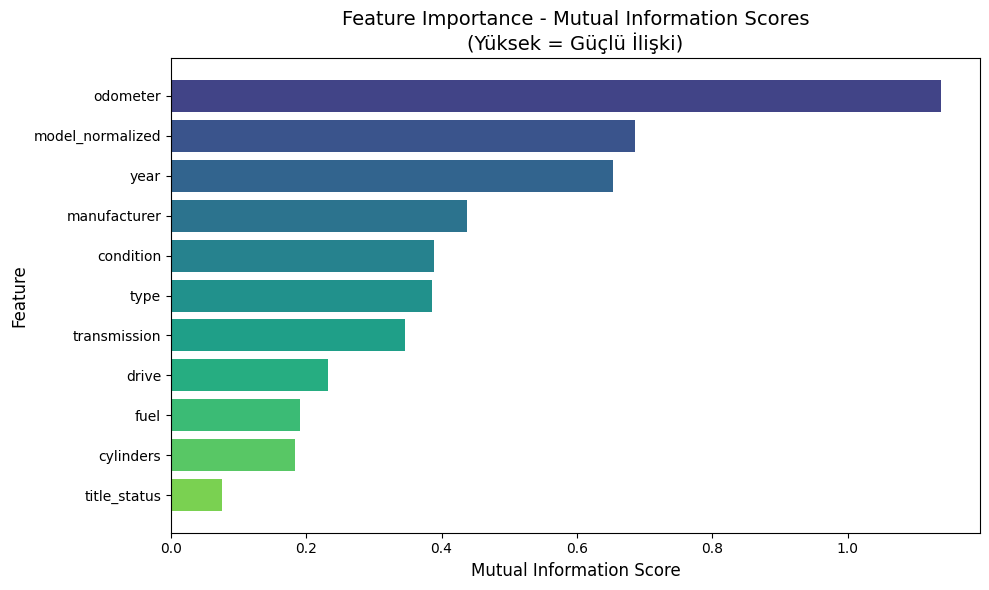

3777

In [12]:
# MUTUAL INFORMATION SCORES TRAİN ÜZERİNDE
print('='*60)
print('MUTUAL INFORMATION SCORES')
print('='*60)

# Sampling
SAMPLE_SIZE = min(50000, len(X_train))
print(f'\nMemory optimizasyonu: {len(X_train):,} -> {SAMPLE_SIZE:,} örnek')

np.random.seed(42)
sample_idx = np.random.choice(len(X_train), size=SAMPLE_SIZE, replace=False)

X_train_sample = X_train.iloc[sample_idx].copy()
y_train_sample = y_train.iloc[sample_idx].copy()

analysis_df = X_train_sample.copy()
analysis_df['price'] = y_train_sample.values

# Kategorik kolonları encode et
categorical_for_mi = ['manufacturer', 'condition', 'fuel', 'title_status', 
                      'transmission', 'drive', 'type', 'model_normalized']

for col in categorical_for_mi:
    le_temp = LabelEncoder()
    analysis_df[col + '_encoded'] = le_temp.fit_transform(analysis_df[col].astype(str))

# Feature'ları hazırla
all_features_for_mi = ['year', 'cylinders', 'odometer'] + [col + '_encoded' for col in categorical_for_mi]
X_mi = analysis_df[all_features_for_mi].astype(np.float32).values
y_mi = analysis_df['price'].astype(np.float32).values

print(f'X_mi shape: {X_mi.shape}')

# MI hesapla
mi_scores = mutual_info_regression(X_mi, y_mi, random_state=42)

feature_names_mi = ['year', 'cylinders', 'odometer'] + categorical_for_mi
mi_df = pd.DataFrame({
    'Feature': feature_names_mi,
    'MI Score': mi_scores
}).sort_values('MI Score', ascending=False)

print('\nMI Scores (Sadece Train verisinden hesaplandı!):')
print(mi_df.to_string(index=False))

# MI SCORES GRAFİĞİ
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(mi_df)))
plt.barh(mi_df['Feature'], mi_df['MI Score'], color=colors)
plt.xlabel('Mutual Information Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance - Mutual Information Scores\n(Yüksek = Güçlü İlişki)', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Temizlik
del X_mi, y_mi, analysis_df, X_train_sample, y_train_sample
import gc
gc.collect()

ANOVA F-TEST (SADECE TRAIN - Sampled!)

ANOVA Sonuçları:
         Feature  F-Statistic       P-Value Significant
           drive  1761.516098  0.000000e+00         Yes
    transmission  1385.813616  0.000000e+00         Yes
            fuel  1375.749466  0.000000e+00         Yes
            type   658.859425  0.000000e+00         Yes
       condition   384.570992  0.000000e+00         Yes
    manufacturer   180.006214  0.000000e+00         Yes
    title_status    85.128303 1.440403e-106         Yes
model_normalized    48.016173  0.000000e+00         Yes


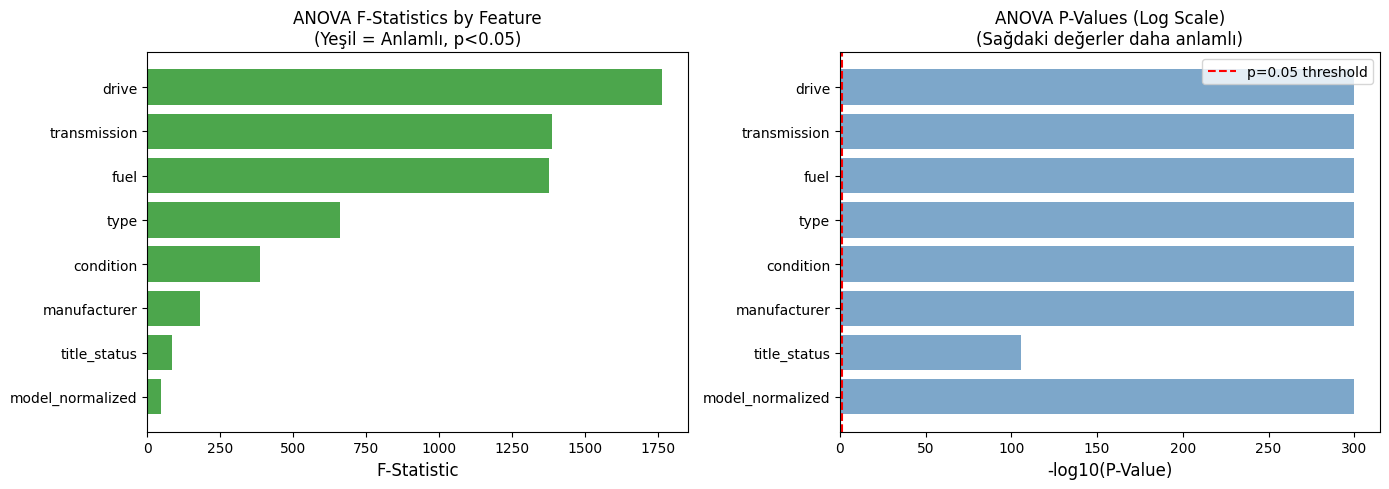

10195

In [13]:
# ANOVA F-TEST - SADECE TRAIN ÜZERİNDE!
print('='*60)
print('ANOVA F-TEST (SADECE TRAIN - Sampled!)')
print('='*60)

# Sampling
SAMPLE_SIZE = min(50000, len(X_train))
np.random.seed(42)
sample_idx = np.random.choice(len(X_train), size=SAMPLE_SIZE, replace=False)

analysis_df = X_train.iloc[sample_idx].copy()
analysis_df['price'] = y_train.iloc[sample_idx].values

anova_results = []
for col in categorical_for_mi:
    groups = [group['price'].values for name, group in analysis_df.groupby(col)]
    if len(groups) > 1:
        f_stat, p_value = stats.f_oneway(*groups)
        anova_results.append({
            'Feature': col,
            'F-Statistic': f_stat,
            'P-Value': p_value,
            'Significant': 'Yes' if p_value < 0.05 else 'No'
        })

anova_df = pd.DataFrame(anova_results).sort_values('F-Statistic', ascending=False)
print('\nANOVA Sonuçları:')
print(anova_df.to_string(index=False))

# 📊 ANOVA GRAFİĞİ
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F-Statistic
colors_f = ['green' if sig == 'Yes' else 'red' for sig in anova_df['Significant']]
axes[0].barh(anova_df['Feature'], anova_df['F-Statistic'], color=colors_f, alpha=0.7)
axes[0].set_xlabel('F-Statistic', fontsize=12)
axes[0].set_title('ANOVA F-Statistics by Feature\n(Yeşil = Anlamlı, p<0.05)', fontsize=12)
axes[0].invert_yaxis()

# P-Value (log scale)
axes[1].barh(anova_df['Feature'], -np.log10(anova_df['P-Value'] + 1e-300), color='steelblue', alpha=0.7)
axes[1].axvline(x=-np.log10(0.05), color='red', linestyle='--', label='p=0.05 threshold')
axes[1].set_xlabel('-log10(P-Value)', fontsize=12)
axes[1].set_title('ANOVA P-Values (Log Scale)\n(Sağdaki değerler daha anlamlı)', fontsize=12)
axes[1].invert_yaxis()
axes[1].legend()

plt.tight_layout()
plt.show()

del analysis_df
gc.collect()

## 5. Feature Engineering

In [14]:
# Feature Engineering train kısmında ayrı test kısmında ayrı olcak şekilde yapıldı)
print('='*60)
print('FEATURE ENGINEERING')
print('='*60)

CURRENT_YEAR = datetime.now().year

# Kopyalar oluştur
X_train_fe = X_train.copy()
X_test_fe = X_test.copy()

# 1) CAR_AGE - Basit hesaplama, leakage yok
print(f'\n1) CAR_AGE oluşturuluyor...')
X_train_fe['car_age'] = CURRENT_YEAR - X_train_fe['year']
X_test_fe['car_age'] = CURRENT_YEAR - X_test_fe['year']
print(f'   ✓ Train mean: {X_train_fe["car_age"].mean():.1f} years')

# 2) MIL_PER_YEAR - Basit hesaplama, leakage yok
print(f'\n2) MIL_PER_YEAR oluşturuluyor...')
X_train_fe['mil_per_year'] = X_train_fe['odometer'] / X_train_fe['car_age'].replace(0, 1)
X_test_fe['mil_per_year'] = X_test_fe['odometer'] / X_test_fe['car_age'].replace(0, 1)
print(f'   ✓ Train mean: {X_train_fe["mil_per_year"].mean():,.0f} miles/year')

# 3) CONDITION_SCORE - Sabit mapping, leakage yok
print(f'\n3) CONDITION_SCORE oluşturuluyor...')
condition_map = {
    'salvage': 1, 'fair': 2, 'good': 3, 'excellent': 4, 
    'like new': 5, 'new': 6, 'unknown': 3
}
X_train_fe['condition_score'] = X_train_fe['condition'].map(condition_map).fillna(3)
X_test_fe['condition_score'] = X_test_fe['condition'].map(condition_map).fillna(3)
print(f'   ✓ Condition score oluşturuldu')

FEATURE ENGINEERING

1) CAR_AGE oluşturuluyor...
   ✓ Train mean: 13.7 years

2) MIL_PER_YEAR oluşturuluyor...
   ✓ Train mean: 6,550 miles/year

3) CONDITION_SCORE oluşturuluyor...
   ✓ Condition score oluşturuldu


In [15]:
# 4) DEPRECIATION_RATE
print('='*60)
print('DEPRECIATION_RATE')
print('='*60)

# Basit yaklaşım: odometer / car_age (yıllık ortalama km)
# Bu zaten mil_per_year ile aynı, farklı bir şey yapalım:

# Manufacturer bazında ortalama odometer (aynı yaştaki arabalar için)
# Train'den hesapla
train_temp = X_train_fe.copy()
train_temp['age_group'] = pd.cut(train_temp['car_age'], bins=[0, 3, 6, 10, 15, 50], labels=['0-3', '3-6', '6-10', '10-15', '15+'])

avg_odometer_by_manu_age = train_temp.groupby(['manufacturer', 'age_group'])['odometer'].mean().to_dict()
overall_avg_odometer = train_temp['odometer'].mean()

def calc_depreciation(row, lookup_dict, fallback):
    key = (row['manufacturer'], row['age_group'])
    expected_odo = lookup_dict.get(key, fallback)
    # Beklenen km'den sapma oranı
    if expected_odo > 0:
        return row['odometer'] / expected_odo
    return 1.0

# Age group ekle
X_train_fe['age_group'] = pd.cut(X_train_fe['car_age'], bins=[0, 3, 6, 10, 15, 50], labels=['0-3', '3-6', '6-10', '10-15', '15+'])
X_test_fe['age_group'] = pd.cut(X_test_fe['car_age'], bins=[0, 3, 6, 10, 15, 50], labels=['0-3', '3-6', '6-10', '10-15', '15+'])

X_train_fe['depreciation_rate'] = X_train_fe.apply(lambda r: calc_depreciation(r, avg_odometer_by_manu_age, overall_avg_odometer), axis=1)
X_test_fe['depreciation_rate'] = X_test_fe.apply(lambda r: calc_depreciation(r, avg_odometer_by_manu_age, overall_avg_odometer), axis=1)

# age_group'u sil
X_train_fe = X_train_fe.drop(columns=['age_group'])
X_test_fe = X_test_fe.drop(columns=['age_group'])

print(f'Train depreciation_rate - mean: {X_train_fe["depreciation_rate"].mean():.4f}, std: {X_train_fe["depreciation_rate"].std():.4f}')
print(f'Test depreciation_rate - mean: {X_test_fe["depreciation_rate"].mean():.4f}, std: {X_test_fe["depreciation_rate"].std():.4f}')

DEPRECIATION_RATE
Train depreciation_rate - mean: 1.0000, std: 0.5854
Test depreciation_rate - mean: 1.0036, std: 0.5939


In [16]:
# 5) LUXURY_BRAND - Sabit liste, leakage yok
print(f'\n5) LUXURY_BRAND oluşturuluyor...')
luxury_brands = ['ferrari', 'lamborghini', 'bentley', 'rolls-royce', 'aston-martin',
                 'maserati', 'mclaren', 'porsche', 'bugatti', 'lotus']
X_train_fe['luxury_brand'] = X_train_fe['manufacturer'].str.lower().isin(luxury_brands).astype(int)
X_test_fe['luxury_brand'] = X_test_fe['manufacturer'].str.lower().isin(luxury_brands).astype(int)
print(f'   ✓ Train luxury: {X_train_fe["luxury_brand"].sum()}')

# 6) ELECTRIC_VEHICLE - Basit flag, leakage yok
print(f'\n6) ELECTRIC_VEHICLE oluşturuluyor...')
X_train_fe['electric_vehicle'] = (X_train_fe['fuel'] == 'electric').astype(int)
X_test_fe['electric_vehicle'] = (X_test_fe['fuel'] == 'electric').astype(int)
print(f'   ✓ Train electric: {X_train_fe["electric_vehicle"].sum()}')

# 7) HIGH_MILEAGE - Sabit threshold, leakage yok
print(f'\n7) HIGH_MILEAGE oluşturuluyor...')
HIGH_MILEAGE_THRESHOLD = 150000  # Sabit değer, train'den hesaplanmıyor
X_train_fe['high_mileage'] = (X_train_fe['odometer'] > HIGH_MILEAGE_THRESHOLD).astype(int)
X_test_fe['high_mileage'] = (X_test_fe['odometer'] > HIGH_MILEAGE_THRESHOLD).astype(int)
print(f'   ✓ Train high mileage: {X_train_fe["high_mileage"].sum()}')

# 8) Year kolonunu çıkar (car_age var)
X_train_fe = X_train_fe.drop(columns=['year'])
X_test_fe = X_test_fe.drop(columns=['year'])

# 9) Log transform (target)
print(f'\n8) TARGET log transform...')
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

print(f'\n{"="*60}')
print('FEATURE ENGINEERING TAMAMLANDI!')
print(f'{"="*60}')
print(f'Train shape: {X_train_fe.shape}')
print(f'Test shape: {X_test_fe.shape}')


5) LUXURY_BRAND oluşturuluyor...
   ✓ Train luxury: 971

6) ELECTRIC_VEHICLE oluşturuluyor...
   ✓ Train electric: 1269

7) HIGH_MILEAGE oluşturuluyor...
   ✓ Train high mileage: 55637

8) TARGET log transform...

FEATURE ENGINEERING TAMAMLANDI!
Train shape: (293958, 17)
Test shape: (73490, 17)


## 6. Preprocessor ve Pipeline Tanımlama

In [17]:
# Feature grupları
numeric_features = ['cylinders', 'odometer', 'car_age', 'mil_per_year', 
                    'condition_score', 'depreciation_rate', 'luxury_brand', 
                    'electric_vehicle', 'high_mileage']

ordinal_features = ['condition', 'title_status']
ordinal_categories = [
    ['salvage', 'fair', 'good', 'excellent', 'like new', 'new', 'unknown'],
    ['parts only', 'missing', 'salvage', 'lien', 'rebuilt', 'clean', 'unknown']
]

# model yerine model_normalized kullanılıyor
nominal_features = ['manufacturer', 'fuel', 'transmission', 'drive', 'type', 'model_normalized']

# ColumnTransformer oluştur
def create_preprocessor():
    return ColumnTransformer([
        ('num', StandardScaler(), numeric_features),
        ('ord', OrdinalEncoder(
            categories=ordinal_categories, 
            handle_unknown='use_encoded_value', 
            unknown_value=-1
        ), ordinal_features),
        ('nom', OrdinalEncoder(
            handle_unknown='use_encoded_value', 
            unknown_value=-1
        ), nominal_features)
    ], remainder='drop')

print('Preprocessor fonksiyonu tanımlandı')
print(f'Numeric features ({len(numeric_features)}): {numeric_features}')
print(f'Ordinal features ({len(ordinal_features)}): {ordinal_features}')
print(f'Nominal features ({len(nominal_features)}): {nominal_features}')

Preprocessor fonksiyonu tanımlandı
Numeric features (9): ['cylinders', 'odometer', 'car_age', 'mil_per_year', 'condition_score', 'depreciation_rate', 'luxury_brand', 'electric_vehicle', 'high_mileage']
Ordinal features (2): ['condition', 'title_status']
Nominal features (6): ['manufacturer', 'fuel', 'transmission', 'drive', 'type', 'model_normalized']


In [18]:
# Değerlendirme fonksiyonu
def evaluate_model(y_true, y_pred, name, verbose=True):
    # y_true ve y_pred log-ölçekte
    r2_log = r2_score(y_true, y_pred)

    # Gerçek fiyatlara dönüştür
    y_true_real = np.expm1(y_true)
    y_pred_real = np.maximum(np.expm1(y_pred), 0)

    r2_real = r2_score(y_true_real, y_pred_real)
    rmse = np.sqrt(mean_squared_error(y_true_real, y_pred_real))
    mae = mean_absolute_error(y_true_real, y_pred_real)

    # MAPE (0 bölme korumalı)
    eps = 1e-9
    denom = np.maximum(np.abs(y_true_real), eps)
    mape = np.mean(np.abs((y_true_real - y_pred_real) / denom)) * 100

    if verbose:
        print(f'\n{name}:')
        print(f'  R2 (log):  {r2_log:.4f}')
        print(f'  R2 (real): {r2_real:.4f}')
        print(f'  RMSE:      ${rmse:,.0f}')
        print(f'  MAE:       ${mae:,.0f}')
        print(f'  MAPE:      {mape:.2f}%')

    return {'r2_log': r2_log, 'r2_real': r2_real, 'rmse': rmse, 'mae': mae, 'mape': mape}

# Sonuçları sakla
results = {}
print('Değerlendirme fonksiyonu tanımlandı')


Değerlendirme fonksiyonu tanımlandı


## 7. Cross-Validation

In [19]:
# KFold tanımla
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print('KFold (5-fold) tanımlandı')

KFold (5-fold) tanımlandı


## 8. MODEL 1: Bagging KNN (Base)

In [20]:
# MODEL 1: BAGGING KNN - BASE
print('='*60)
print('MODEL 1: BAGGING KNN (BASE)')
print('='*60)

# Pipeline oluştur
bagging_knn_base_pipeline = Pipeline([
    ('preprocessor', create_preprocessor()),
    ('model', BaggingRegressor(
        estimator=KNeighborsRegressor(n_neighbors=5, weights='uniform', n_jobs=-1),
        n_estimators=10,
        max_samples=1.0,
        max_features=1.0,
        n_jobs=-1,
        random_state=42
    ))
])

# Cross-validation
print('\n Cross-Validation (Pipeline ile - Her fold için ayrı fit)...')
bagging_base_cv_scores = cross_val_score(
    bagging_knn_base_pipeline, X_train_fe, y_train_log, 
    cv=kf, scoring='r2', n_jobs=-1
)
print(f'   CV R2 Scores: {bagging_base_cv_scores}')
print(f'   Mean CV R2: {bagging_base_cv_scores.mean():.4f} (+/- {bagging_base_cv_scores.std():.4f})')

# Final eğitim
print('\n Final eğitim (tüm train verisi)...')
bagging_knn_base_pipeline.fit(X_train_fe, y_train_log)

# Test değerlendirmesi
y_pred_bagging_base = bagging_knn_base_pipeline.predict(X_test_fe)
results['Bagging KNN (Base)'] = evaluate_model(y_test_log, y_pred_bagging_base, 'Bagging KNN (Base)')

MODEL 1: BAGGING KNN (BASE)

 Cross-Validation (Pipeline ile - Her fold için ayrı fit)...
   CV R2 Scores: [0.84277904 0.84058455 0.84416845 0.8382386  0.84135323]
   Mean CV R2: 0.8414 (+/- 0.0020)

 Final eğitim (tüm train verisi)...

Bagging KNN (Base):
  R2 (log):  0.8505
  R2 (real): 0.8817
  RMSE:      $4,924
  MAE:       $2,453
  MAPE:      22.60%


## 9. MODEL 2: CatBoost (Base)

In [21]:
# MODEL 2: CATBOOST - BASE (Native Categorical)
print('='*60)
print('MODEL 2: CATBOOST (BASE - Native Categorical)')
print('='*60)

# CatBoost için kategorik kolon indeksleri
cat_cols = ordinal_features + nominal_features
cat_feature_indices = [X_train_fe.columns.get_loc(c) for c in cat_cols if c in X_train_fe.columns]

# Pipeline oluştur (preprocessor YOK: CatBoost kategorikleri native işlesin kendisi içinde)
catboost_base_pipeline = Pipeline([
    ('model', CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=6,
        verbose=0,
        random_state=42,
        task_type='GPU',
        cat_features=cat_feature_indices
    ))
])

# Cross-validation
print('\n Cross-Validation...')
catboost_base_cv_scores = cross_val_score(
    catboost_base_pipeline, X_train_fe, y_train_log,
    cv=kf, scoring='r2', n_jobs=1
)
print(f'   CV R2 Scores: {catboost_base_cv_scores}')
print(f'   Mean CV R2: {catboost_base_cv_scores.mean():.4f} (+/- {catboost_base_cv_scores.std():.4f})')

# Final eğitim
print('\n Final eğitim (tüm train verisi)...')
catboost_base_pipeline.fit(X_train_fe, y_train_log)

# Test değerlendirmesi
y_pred_catboost_base = catboost_base_pipeline.predict(X_test_fe)
results['CatBoost (Base)'] = evaluate_model(y_test_log, y_pred_catboost_base, 'CatBoost (Base)')


MODEL 2: CATBOOST (BASE - Native Categorical)

 Cross-Validation...
   CV R2 Scores: [0.86842435 0.86469977 0.86933971 0.8640064  0.8653615 ]
   Mean CV R2: 0.8664 (+/- 0.0021)

 Final eğitim (tüm train verisi)...

CatBoost (Base):
  R2 (log):  0.8650
  R2 (real): 0.8712
  RMSE:      $5,139
  MAE:       $3,032
  MAPE:      23.75%


## 10. MODEL 3: Bagging KNN (Hyperparameter Tuned)

In [22]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
import time

# %50 subsample (tuning için)
X_tune, _, y_tune, _ = train_test_split(
    X_train_fe, y_train_log, test_size=0.5, random_state=42
)

bagging_knn_tune_pipeline = Pipeline([
    ('preprocessor', create_preprocessor()),
    ('model', BaggingRegressor(
        estimator=KNeighborsRegressor(n_jobs=-1),
        n_jobs=-1,
        random_state=42
    ))
])

param_dist_bagging = {
    'model__estimator__n_neighbors': [5, 10, 15, 20],
    'model__estimator__weights': ['uniform', 'distance'],
    'model__estimator__p': [1, 2],
    'model__n_estimators': [10, 15, 20, 25],
    'model__max_samples': [0.7, 0.8, 0.9, 1.0],
    'model__max_features': [0.7, 0.8, 0.9, 1.0]
}

start_time = time.time()

halving_search_bagging = HalvingRandomSearchCV(
    estimator=bagging_knn_tune_pipeline,
    param_distributions=param_dist_bagging,
    scoring='r2',
    cv=2,
    factor=3,
    resource='n_samples',
    min_resources='smallest',   # <-- exhaust yerine
    max_resources='auto',
    n_candidates=30,            # <-- kaç kombinasyonla başlayacağını sabitle (hız için 20-40 iyi)
    random_state=42,
    n_jobs=-1,
    verbose=1,
    refit=True
)

halving_search_bagging.fit(X_tune, y_tune)
elapsed = time.time() - start_time

print(f"Tuning süresi: {elapsed:.1f} sn")
print("Best params:", halving_search_bagging.best_params_)
print("Best CV R2:", halving_search_bagging.best_score_)

best_bagging_pipeline = halving_search_bagging.best_estimator_
best_bagging_pipeline.fit(X_train_fe, y_train_log)

y_pred_bagging_tuned = best_bagging_pipeline.predict(X_test_fe)
results['Bagging KNN (Halving + Subsample)'] = evaluate_model(
    y_test_log, y_pred_bagging_tuned, 'Bagging KNN (Halving + Subsample)'
)


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 10
min_resources_: 4
max_resources_: 146979
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 30
n_resources: 4
Fitting 2 folds for each of 30 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 10
n_resources: 12
Fitting 2 folds for each of 10 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 4
n_resources: 36
Fitting 2 folds for each of 4 candidates, totalling 8 fits
----------
iter: 3
n_candidates: 2
n_resources: 108
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Tuning süresi: 15.1 sn
Best params: {'model__n_estimators': 20, 'model__max_samples': 0.9, 'model__max_features': 0.9, 'model__estimator__weights': 'distance', 'model__estimator__p': 1, 'model__estimator__n_neighbors': 10}
Best CV R2: 0.21529649548148044

Bagging KNN (Halving + Subsample):
  R2 (log):  0.8919
  R2 (real): 0.9212
  RMSE:      $4,020
  MAE:       $1,755
  MAPE:      17.58%


## 11. MODEL 4: CatBoost (Hyperparameter Tuned)

In [31]:
# ============================================================
# MODEL 4: CATBOOST - HYPERPARAMETER TUNING (Native Categorical)
# ============================================================
print('='*60)
print('MODEL 4: CATBOOST (HYPERPARAMETER TUNING - Native Categorical)')
print('='*60)


cat_cols = ordinal_features + nominal_features
cat_feature_indices = [X_train_fe.columns.get_loc(c) for c in cat_cols if c in X_train_fe.columns]

# Pipeline oluştur (preprocessor YOK)
catboost_tune_pipeline = Pipeline([
    ('model', CatBoostRegressor(
        verbose=0,
        random_state=42,
        task_type='GPU',
        cat_features=cat_feature_indices
    ))
])

# Hyperparameter grid 
param_dist_catboost = {
    'model__iterations': [3000, 5000, 7500],
    'model__learning_rate': [0.03, 0.05, 0.1],
    'model__depth': [6, 8, 10],
    'model__l2_leaf_reg': [1, 3, 5, 7]
}

print('\n RandomizedSearchCV başlıyor...')
start_time = time.time()

random_search_catboost = RandomizedSearchCV(
    estimator=catboost_tune_pipeline,
    param_distributions=param_dist_catboost,
    n_iter=15,
    cv=2,
    scoring='r2',
    n_jobs=1,
    random_state=42,
    verbose=1
)

random_search_catboost.fit(X_train_fe, y_train_log)
elapsed = time.time() - start_time

print(f'\n Tuning süresi: {elapsed:.1f} saniye')
print(f'\n En iyi parametreler:')
for param, value in random_search_catboost.best_params_.items():
    print(f'   {param}: {value}')
print(f'\n   Best CV R2: {random_search_catboost.best_score_:.4f}')

# En iyi model
best_catboost_pipeline = random_search_catboost.best_estimator_

# Test değerlendirmesi
y_pred_catboost_tuned = best_catboost_pipeline.predict(X_test_fe)
results['CatBoost (Tuned)'] = evaluate_model(y_test_log, y_pred_catboost_tuned, 'CatBoost (Tuned)')


MODEL 4: CATBOOST (HYPERPARAMETER TUNING - Native Categorical)

 RandomizedSearchCV başlıyor...
Fitting 2 folds for each of 15 candidates, totalling 30 fits

 Tuning süresi: 4459.0 saniye

 En iyi parametreler:
   model__learning_rate: 0.1
   model__l2_leaf_reg: 7
   model__iterations: 5000
   model__depth: 10

   Best CV R2: 0.8896

CatBoost (Tuned):
  R2 (log):  0.8980
  R2 (real): 0.9174
  RMSE:      $4,116
  MAE:       $2,222
  MAPE:      18.67%


In [2]:
# ============================================================
# Best CatBoost -> Feature Importance (Native Categorical)
# ============================================================
import pandas as pd
from catboost import Pool

best_catboost_pipeline = random_search_catboost.best_estimator_
best_cb = best_catboost_pipeline.named_steps['model']

pool = Pool(X_train_fe, y_train_log, cat_features=cat_feature_indices)

fi = best_cb.get_feature_importance(pool, type='FeatureImportance')
fi_df = (pd.DataFrame({'feature': X_train_fe.columns, 'importance': fi})
         .sort_values('importance', ascending=False))

print("\n=== Top 10 Feature Importance (Best CatBoost) ===")
print(fi_df.head(10).to_string(index=False))


NameError: name 'random_search_catboost' is not defined

## 12. MODEL 5: PCA + CatBoost Deneyi

MODEL 5: PCA + CATBOOST DENEYİ

 Cross-Validation (PCA pipeline içinde!)...
   CV R2 Scores: [0.88876895 0.88636976 0.89037309 0.88633943 0.88706295]
   Mean CV R2: 0.8878 (+/- 0.0016)

 Final eğitim...

 PCA Açıklanan Varyans: 0.9999 (toplam)
   Bileşen başına: [9.93524776e-01 5.29240742e-03 6.34772882e-04 1.30978851e-04
 1.11183067e-04 5.53747695e-05 4.27573655e-05 3.93390693e-05
 3.74922991e-05 3.69166103e-05]


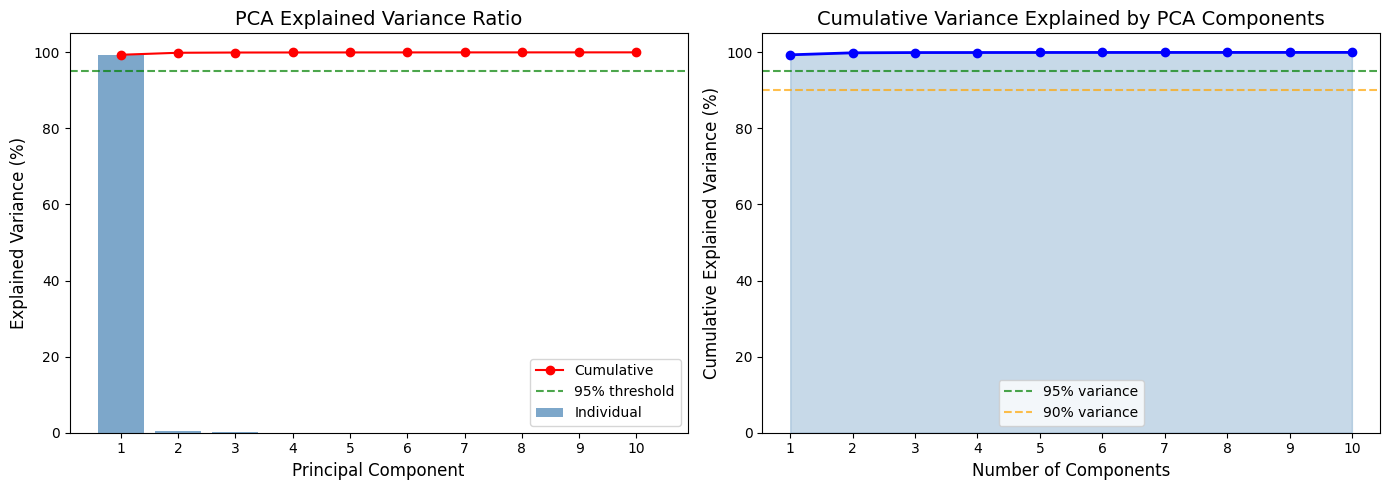


Varyansın %90'ı için gereken bileşen sayısı: 1
Varyansın %95'i için gereken bileşen sayısı: 1

PCA + CatBoost:
  R2 (log):  0.8892
  R2 (real): 0.9100
  RMSE:      $4,297
  MAE:       $2,261
  MAPE:      19.36%

 PCA Etkisi Karşılaştırması:
   CatBoost (Tuned) R2: 0.9174
   PCA + CatBoost R2:   0.9100
   Fark: -0.0074
    PCA performansı korudu veya artırdı


In [32]:
# MODEL 5: PCA + CATBOOST DENEYİ
print('='*60)
print('MODEL 5: PCA + CATBOOST DENEYİ')
print('='*60)

# En iyi CatBoost parametrelerini al
best_catboost_params = random_search_catboost.best_params_

# PCA + CatBoost Pipeline
pca_catboost_pipeline = Pipeline([
    ('preprocessor', create_preprocessor()),
    ('pca', PCA(n_components=10)),
    ('model', CatBoostRegressor(
        iterations=best_catboost_params.get('model__iterations', 5000),
        learning_rate=best_catboost_params.get('model__learning_rate', 0.05),
        depth=best_catboost_params.get('model__depth', 8),
        l2_leaf_reg=best_catboost_params.get('model__l2_leaf_reg', 5),
        verbose=0,
        random_state=42,
        task_type='GPU'
    ))
])

# Cross-validation
print('\n Cross-Validation (PCA pipeline içinde!)...')
pca_cv_scores = cross_val_score(
    pca_catboost_pipeline, X_train_fe, y_train_log,
    cv=kf, scoring='r2', n_jobs=1
)
print(f'   CV R2 Scores: {pca_cv_scores}')
print(f'   Mean CV R2: {pca_cv_scores.mean():.4f} (+/- {pca_cv_scores.std():.4f})')

# Final eğitim
print('\n Final eğitim...')
pca_catboost_pipeline.fit(X_train_fe, y_train_log)

# PCA Analizi
pca_component = pca_catboost_pipeline.named_steps['pca']
explained_variance = pca_component.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f'\n PCA Açıklanan Varyans: {sum(explained_variance):.4f} (toplam)')
print(f'   Bileşen başına: {explained_variance}')

# PCA EXPLAINED VARIANCE GRAFİĞİ
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Her bileşenin açıkladığı varyans
components = range(1, len(explained_variance) + 1)
axes[0].bar(components, explained_variance * 100, color='steelblue', alpha=0.7, label='Individual')
axes[0].plot(components, cumulative_variance * 100, 'ro-', label='Cumulative')
axes[0].axhline(y=95, color='green', linestyle='--', alpha=0.7, label='95% threshold')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance (%)', fontsize=12)
axes[0].set_title('PCA Explained Variance Ratio', fontsize=14)
axes[0].legend()
axes[0].set_xticks(components)

# 2. Cumulative variance
axes[1].fill_between(components, cumulative_variance * 100, alpha=0.3, color='steelblue')
axes[1].plot(components, cumulative_variance * 100, 'b-o', linewidth=2)
axes[1].axhline(y=95, color='green', linestyle='--', alpha=0.7, label='95% variance')
axes[1].axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% variance')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance (%)', fontsize=12)
axes[1].set_title('Cumulative Variance Explained by PCA Components', fontsize=14)
axes[1].legend()
axes[1].set_xticks(components)
axes[1].set_ylim(0, 105)

plt.tight_layout()
plt.show()

# Kaç bileşenle %90 ve %95 açıklanır?
n_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f'\nVaryansın %90\'ı için gereken bileşen sayısı: {n_90}')
print(f'Varyansın %95\'i için gereken bileşen sayısı: {n_95}')

# Test değerlendirmesi
y_pred_pca = pca_catboost_pipeline.predict(X_test_fe)
results['PCA + CatBoost'] = evaluate_model(y_test_log, y_pred_pca, 'PCA + CatBoost')

# PCA etkisi karşılaştırması
print('\n PCA Etkisi Karşılaştırması:')
print(f'   CatBoost (Tuned) R2: {results["CatBoost (Tuned)"]["r2_real"]:.4f}')
print(f'   PCA + CatBoost R2:   {results["PCA + CatBoost"]["r2_real"]:.4f}')
fark = results['PCA + CatBoost']['r2_real'] - results['CatBoost (Tuned)']['r2_real']
print(f'   Fark: {fark:+.4f}')
if fark < -0.01:
    print('    PCA performans kaybına yol açtı')
else:
    print('    PCA performansı korudu veya artırdı')

## 13. MODEL 6: Voting Ensemble (Bagging Tuned + CatBoost Tuned)

In [33]:
# MODEL 6: VOTING ENSEMBLE
print('='*60)
print('MODEL 6: VOTING ENSEMBLE (Bagging Tuned + CatBoost Tuned)')
print('='*60)

# Tuned modellerin tahminlerini kullan
# Ağırlıklar: CatBoost genelde daha iyi performans gösterir
WEIGHT_BAGGING = 0.4
WEIGHT_CATBOOST = 0.6

print(f'\nAğırlıklar: Bagging={WEIGHT_BAGGING}, CatBoost={WEIGHT_CATBOOST}')

# Voting tahminleri (zaten eğitilmiş modeller)
y_pred_voting = WEIGHT_BAGGING * y_pred_bagging_tuned + WEIGHT_CATBOOST * y_pred_catboost_tuned

# Test değerlendirmesi
results['Voting Ensemble'] = evaluate_model(y_test_log, y_pred_voting, 'Voting Ensemble')

MODEL 6: VOTING ENSEMBLE (Bagging Tuned + CatBoost Tuned)

Ağırlıklar: Bagging=0.4, CatBoost=0.6

Voting Ensemble:
  R2 (log):  0.9055
  R2 (real): 0.9277
  RMSE:      $3,849
  MAE:       $1,943
  MAPE:      17.34%


In [35]:
# Voting Ensemble için Manual Cross-Validation
print('='*60)
print('VOTING ENSEMBLE - MANUAL CV Data leakage ın önüne geçmek için')
print('='*60)

# En iyi parametreleri al
best_bagging_params = halving_search_bagging.best_params_
best_catboost_params = random_search_catboost.best_params_

voting_cv_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_fe), 1):
    # Fold verilerini ayır - HAM VERİ!
    X_fold_train = X_train_fe.iloc[train_idx]
    X_fold_val = X_train_fe.iloc[val_idx]
    y_fold_train = y_train_log.iloc[train_idx]
    y_fold_val = y_train_log.iloc[val_idx]
    
    # KRİTİK: Her fold için preprocessing AYRI fit ediliyor!
    # Bagging KNN - Pipeline ile (tuned parametreler)
    bag_pipeline = Pipeline([
        ('preprocessor', create_preprocessor()),
        ('model', BaggingRegressor(
            estimator=KNeighborsRegressor(
                n_neighbors=best_bagging_params.get('model__estimator__n_neighbors', 15),
                weights=best_bagging_params.get('model__estimator__weights', 'distance'),
                p=best_bagging_params.get('model__estimator__p', 1),
                n_jobs=-1
            ),
            n_estimators=best_bagging_params.get('model__n_estimators', 25),
            max_samples=best_bagging_params.get('model__max_samples', 1.0),
            max_features=best_bagging_params.get('model__max_features', 0.8),
            n_jobs=-1,
            random_state=42
        ))
    ])
    bag_pipeline.fit(X_fold_train, y_fold_train)
    y_pred_bag_fold = bag_pipeline.predict(X_fold_val)
    
    # CatBoost - Pipeline ile (tuned parametreler)
    cat_pipeline = Pipeline([
        ('preprocessor', create_preprocessor()),
        ('model', CatBoostRegressor(
            iterations=best_catboost_params.get('model__iterations', 5000),
            learning_rate=best_catboost_params.get('model__learning_rate', 0.05),
            depth=best_catboost_params.get('model__depth', 8),
            l2_leaf_reg=best_catboost_params.get('model__l2_leaf_reg', 5),
            verbose=0,
            random_state=42
        ))
    ])
    cat_pipeline.fit(X_fold_train, y_fold_train)
    y_pred_cat_fold = cat_pipeline.predict(X_fold_val)
    
    # Voting
    y_pred_voting_fold = WEIGHT_BAGGING * y_pred_bag_fold + WEIGHT_CATBOOST * y_pred_cat_fold
    
    # R2 hesapla
    fold_r2 = r2_score(y_fold_val, y_pred_voting_fold)
    voting_cv_scores.append(fold_r2)
    print(f'Fold {fold}: R2 = {fold_r2:.4f}')

print(f'\nOrtalama CV R2: {np.mean(voting_cv_scores):.4f} (+/- {np.std(voting_cv_scores):.4f})')
print('\nHer fold için preprocessing AYRI fit edildi - Data Leakage yok')

VOTING ENSEMBLE - MANUAL CV Data leakage ın önüne geçmek için
Fold 1: R2 = 0.9044
Fold 2: R2 = 0.9003
Fold 3: R2 = 0.9055
Fold 4: R2 = 0.9012
Fold 5: R2 = 0.9026

Ortalama CV R2: 0.9028 (+/- 0.0019)

Her fold için preprocessing AYRI fit edildi - Data Leakage yok


## 14. Model Karşılaştırması ve Sonuçlar

In [36]:
# MODEL KARŞILAŞTIRMASI
print('='*60)
print('MODEL KARŞILAŞTIRMASI')
print('='*60)

# Sonuç DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('r2_real', ascending=False)

print('\nTest Seti Performansları (R2 real sıralı):')
print(results_df.to_string())

# En iyi model
best_model_name = results_df.index[0]
best_r2_real = results_df.loc[best_model_name, 'r2_real']
best_r2_log = results_df.loc[best_model_name, 'r2_log']
best_rmse = results_df.loc[best_model_name, 'rmse']
best_mae = results_df.loc[best_model_name, 'mae']
best_mape = results_df.loc[best_model_name, 'mape']

print(f'\nEN İYİ MODEL: {best_model_name}')
print(f'   R2 (log):  {best_r2_log:.4f}')
print(f'   R2 (real): {best_r2_real:.4f}')
print(f'   RMSE: ${best_rmse:,.0f}')
print(f'   MAE:  ${best_mae:,.0f}')
print(f'   MAPE: {best_mape:.2f}%')


MODEL KARŞILAŞTIRMASI

Test Seti Performansları (R2 real sıralı):
                                     r2_log   r2_real         rmse          mae       mape
Voting Ensemble                    0.905530  0.927728  3849.488529  1943.442494  17.335044
Bagging KNN (Halving + Subsample)  0.891911  0.921199  4019.604063  1754.938203  17.576997
CatBoost (Tuned)                   0.898013  0.917389  4115.610730  2222.270512  18.665469
PCA + CatBoost                     0.889209  0.909955  4296.823483  2260.609687  19.362927
Bagging KNN (Base)                 0.850480  0.881733  4924.334487  2452.683344  22.603132
CatBoost (Base)                    0.864979  0.871192  5139.106800  3032.038752  23.748011

EN İYİ MODEL: Voting Ensemble
   R2 (log):  0.9055
   R2 (real): 0.9277
   RMSE: $3,849
   MAE:  $1,943
   MAPE: 17.34%


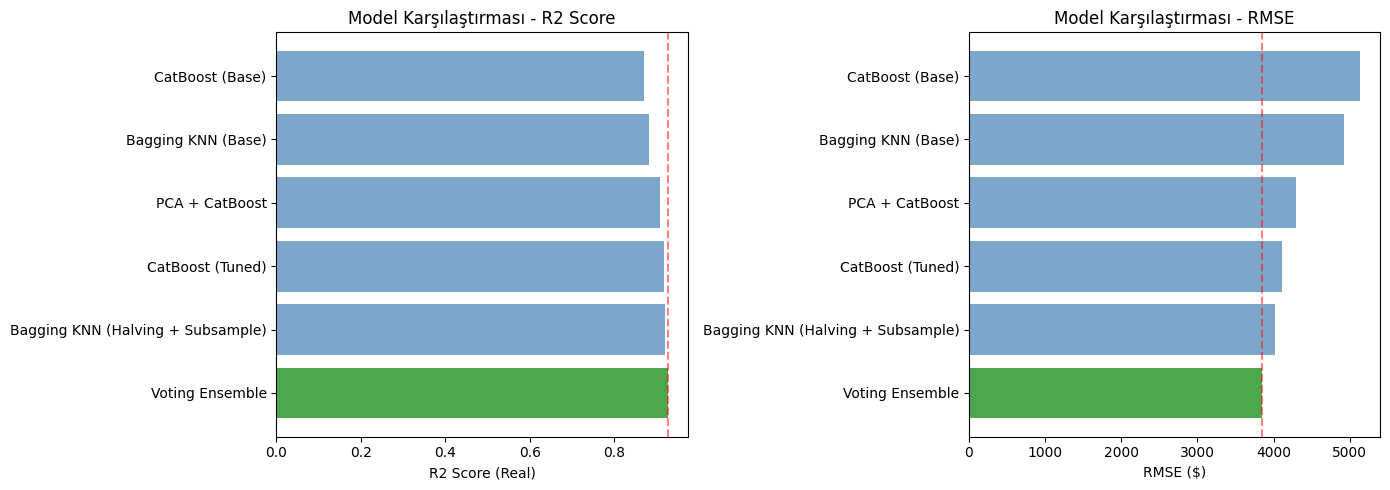

In [37]:
# Görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R2 karşılaştırması
colors = ['green' if name == best_model_name else 'steelblue' for name in results_df.index]
axes[0].barh(results_df.index, results_df['r2_real'], color=colors, alpha=0.7)
axes[0].set_xlabel('R2 Score (Real)')
axes[0].set_title('Model Karşılaştırması - R2 Score')
axes[0].axvline(x=results_df['r2_real'].max(), color='red', linestyle='--', alpha=0.5)

# RMSE karşılaştırması
axes[1].barh(results_df.index, results_df['rmse'], color=colors, alpha=0.7)
axes[1].set_xlabel('RMSE ($)')
axes[1].set_title('Model Karşılaştırması - RMSE')
axes[1].axvline(x=results_df['rmse'].min(), color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 15. Sonuç ve Özet

In [38]:
# Sonuç özeti 
print('='*60)
print('SONUÇ ÖZETİ')
print('='*60)

print('\nProjenin Final hali:')
print('   1) Veri temizleme + null doldurma (split sonrası, sadece train istatistikleriyle)')
print('   2) Feature engineering ve preprocessing (pipeline içinde)')
print('   3) Birden fazla modelin eğitimi ve karşılaştırılması')
print('   4) CatBoost için native categorical kullanımı')
print('   5) En iyi modellerle ensemble (Voting) denemesi')
print('   6) Performans raporlama: R2_log, R2_real, RMSE, MAE, MAPE')

print('\nData Leakage önlemleri uygulandı:')
print('   1. Null değerler split sonrası train istatistikleriyle dolduruldu')
print('   2. Preprocessing/Encoder sadece train üzerinde fit edilip test’e uygulandı')
print('   3. CV sırasında her fold için preprocessing yeniden fit edildi')
print('   4. (Varsa) PCA pipeline içinde tutuldu')

print('\nModel karşılaştırma metrikleri:')
print('   - R2_log  : log(price) üzerinde açıklanan varyans')
print('   - R2_real : gerçek fiyat ölçeğinde açıklanan varyans')
print('   - RMSE    : gerçek fiyat ölçeğinde hata (büyük hataya duyarlı)')
print('   - MAE     : gerçek fiyat ölçeğinde ortalama mutlak hata')
print('   - MAPE    : yüzde hata (oransal performans)')

print(f'\nEn İyi Model: {best_model_name}')
print(f'   R2_log : {best_r2_log:.4f}')
print(f'   R2_real: {best_r2_real:.4f}')
print(f'   RMSE   : ${best_rmse:,.0f}')
print(f'   MAE    : ${best_mae:,.0f}')
print(f'   MAPE   : {best_mape:.2f}%')

print('='*60)


SONUÇ ÖZETİ

Projenin Final hali:
   1) Veri temizleme + null doldurma (split sonrası, sadece train istatistikleriyle)
   2) Feature engineering ve preprocessing (pipeline içinde)
   3) Birden fazla modelin eğitimi ve karşılaştırılması
   4) CatBoost için native categorical kullanımı
   5) En iyi modellerle ensemble (Voting) denemesi
   6) Performans raporlama: R2_log, R2_real, RMSE, MAE, MAPE

Data Leakage önlemleri uygulandı:
   1. Null değerler split sonrası train istatistikleriyle dolduruldu
   2. Preprocessing/Encoder sadece train üzerinde fit edilip test’e uygulandı
   3. CV sırasında her fold için preprocessing yeniden fit edildi
   4. (Varsa) PCA pipeline içinde tutuldu

Model karşılaştırma metrikleri:
   - R2_log  : log(price) üzerinde açıklanan varyans
   - R2_real : gerçek fiyat ölçeğinde açıklanan varyans
   - RMSE    : gerçek fiyat ölçeğinde hata (büyük hataya duyarlı)
   - MAE     : gerçek fiyat ölçeğinde ortalama mutlak hata
   - MAPE    : yüzde hata (oransal performans)